<a href="https://colab.research.google.com/github/Rudy-Nzau/Time-Series-Forecasting/blob/main/Machine_learning_Time_Series_Forecasting_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIME SERIES FORCASTING : XGBoost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


color_pal = sns.color_palette 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

In [2]:
!pip install pycodestyle_magic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#installing flake8
!pip install flake8

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 7.4 MB/s eta 0:00:00


In [4]:
#activating the pycodestyle magic
%load_ext pycodestyle_magic

### Types of Time Series Data
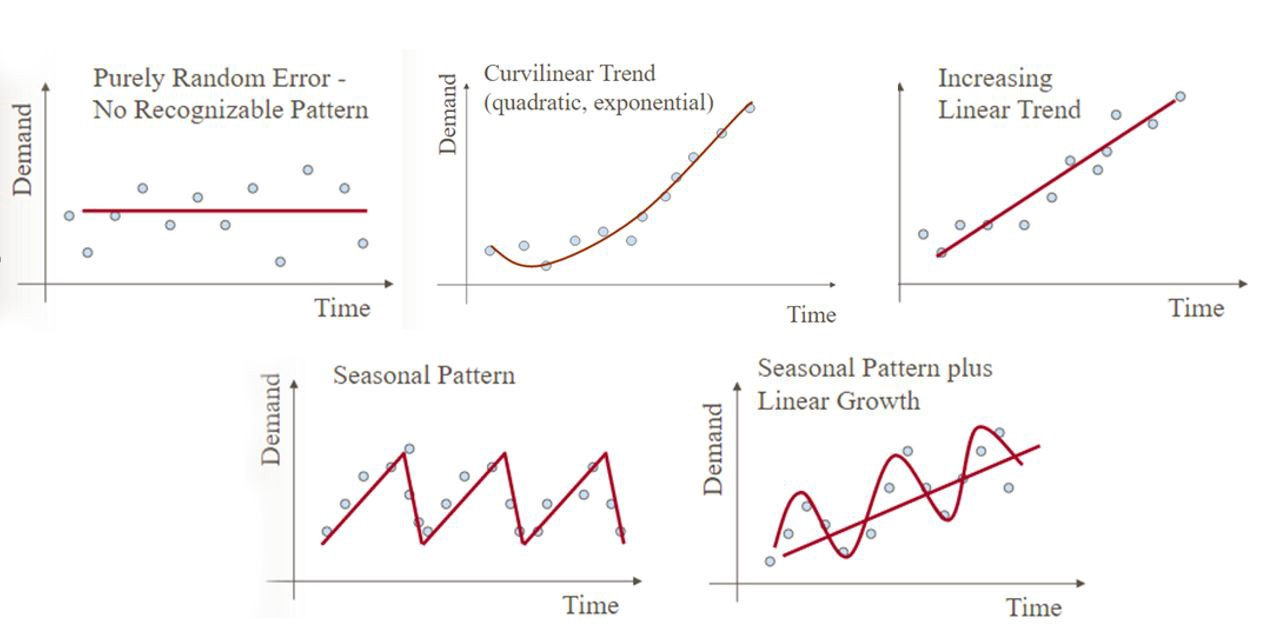

In [5]:
 df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PJME_hourly.csv')
 df = df.set_index('Datetime')
 df.index = pd.to_datetime(df.index)

In [6]:
color_pal = sns.color_palette 

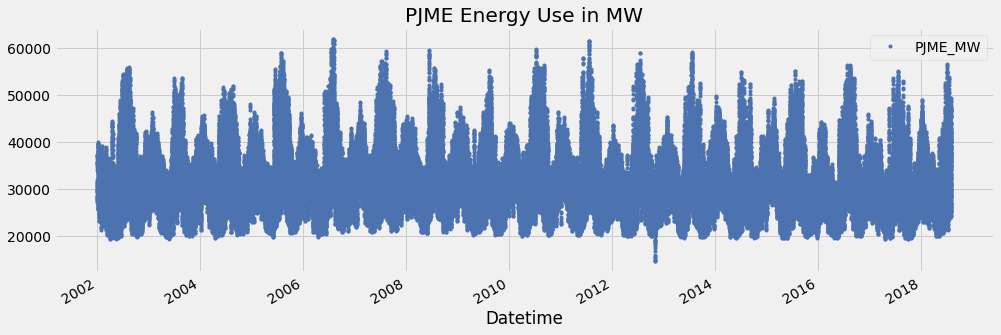

In [7]:
df.plot(style='.', 
        figsize=(15, 5), 
        color=color_pal('deep'), 
        title='PJME Energy Use in MW')
plt.show()

## Train / Test Split

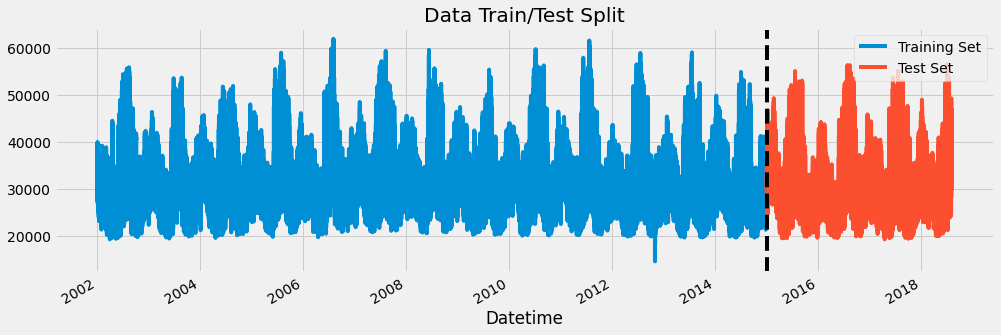

In [8]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot (ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot (ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

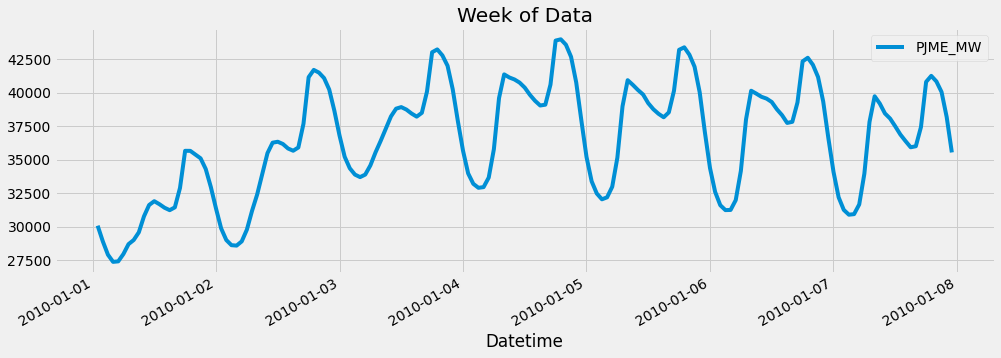

In [9]:
# what a single week of data looks like
df.loc[(df.index > '01-01-2010') & 
       (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week of Data')
       
plt.show()

## Feature Creation

In [10]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

## Visualize  our Feature / Target Relationship

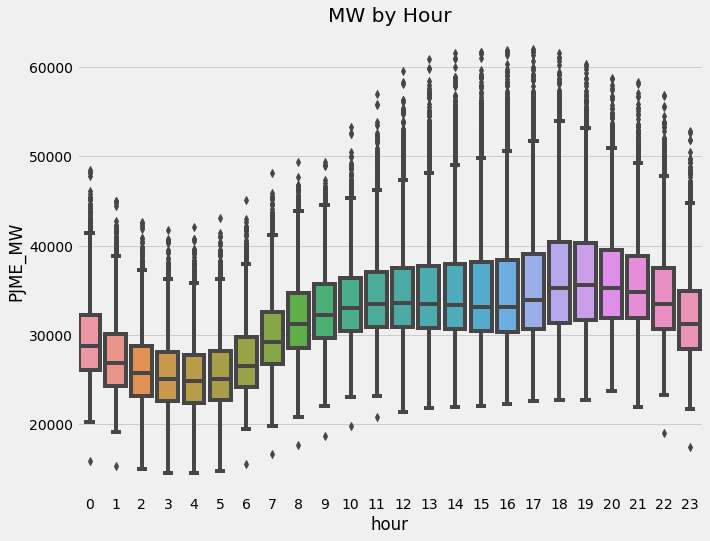

In [11]:
 fig, ax = plt.subplots(figsize=(10, 8))
 sns.boxplot(data=df, x='hour', y='PJME_MW')
 ax.set_title('MW by Hour')
 plt.show()

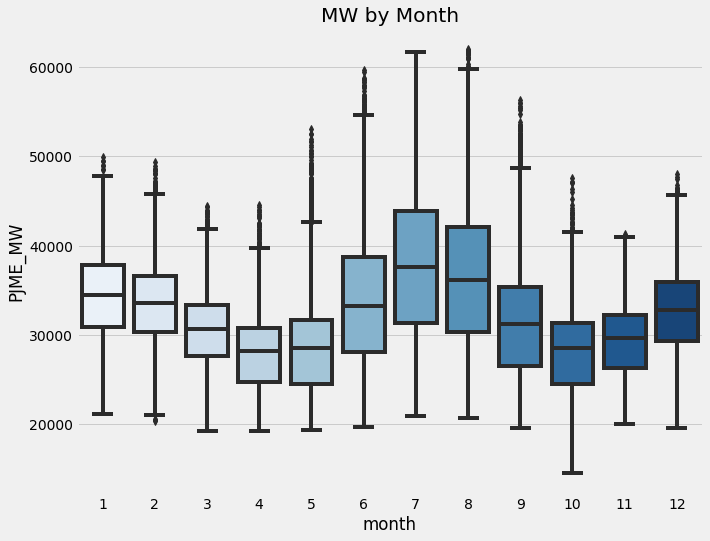

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

## Creat our Model

In [13]:
train = create_features(train)
test = create_features(test)

In [14]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [15]:
# let's define our features 
#which are our columns we created
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear']
TARGET = 'PJME_MW'

In [16]:
# making our training & test datasets

X_train = train[FEATURES]
Y_train = train [TARGET]

X_test = test[FEATURES]
Y_test = test [TARGET]

In [17]:
# creating a regression model using xgboost

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, Y_train,
        eval_set=[(X_train, Y_train), (X_test, Y_test)],
        verbose=100)

[15:09:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.1	validation_1-rmse:31657.1
[100]	validation_0-rmse:12581.2	validation_1-rmse:11743.7
[200]	validation_0-rmse:5835.05	validation_1-rmse:5365.67
[300]	validation_0-rmse:3915.7	validation_1-rmse:4020.66
[400]	validation_0-rmse:3443.11	validation_1-rmse:3853.4
[500]	validation_0-rmse:3285.31	validation_1-rmse:3805.31
[600]	validation_0-rmse:3201.91	validation_1-rmse:3772.44
[700]	validation_0-rmse:3148.12	validation_1-rmse:3750.92
[800]	validation_0-rmse:3109.22	validation_1-rmse:3733.9
[900]	validation_0-rmse:3079.37	validation_1-rmse:3725.61
[999]	validation_0-rmse:3052.71	validation_1-rmse:3722.92


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

## Feature Importance

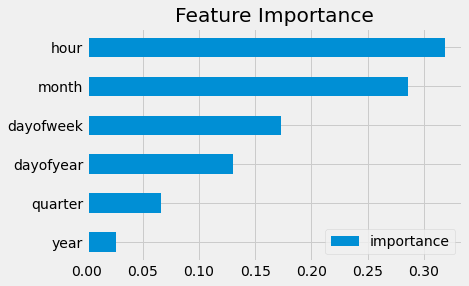

In [18]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns= ['importance'] )

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test

Text(0.5, 1.0, 'Raw Dat and Prediction')

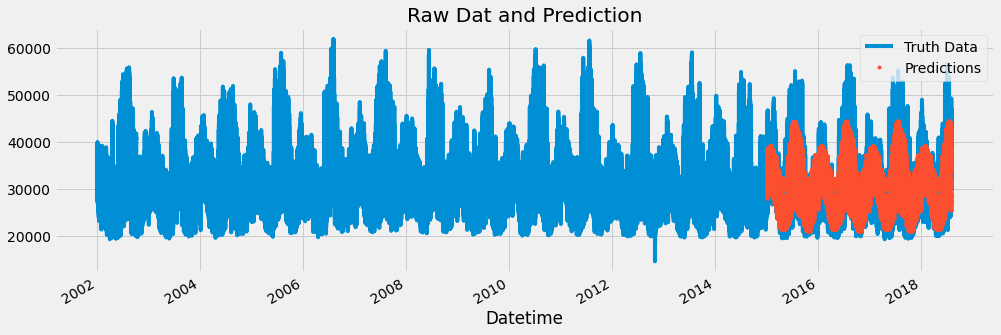

In [19]:
# creating a column prediction using our regressor

test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')

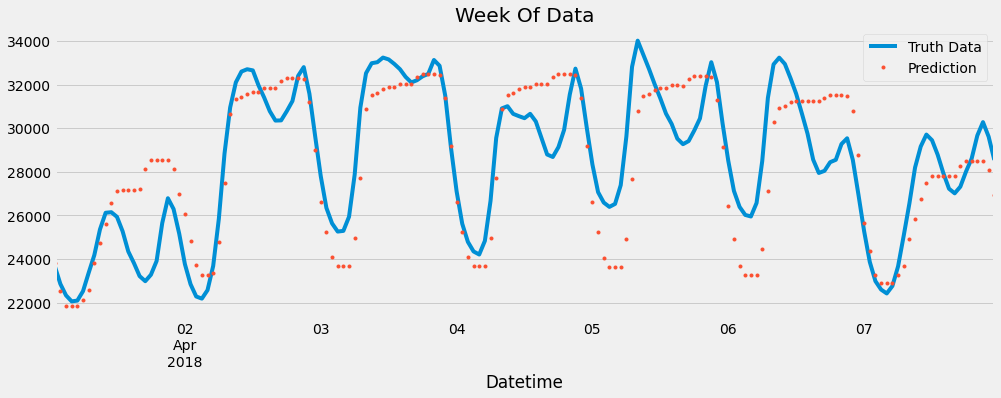

In [20]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [22]:
 score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
 print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3722.92


## Calculate Error
- Look at the worts and the best predicted days

In [25]:
test ['error'] = np.abs(test[TARGET] - test['prediction'])

In [26]:
test['date'] = test.index.date

In [30]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    12853.568034
2016-08-14    12796.636312
2016-09-10    11369.115804
2015-02-20    10931.238200
2016-09-09    10877.764323
2018-01-06    10475.434652
2016-08-12    10138.022217
2015-02-21     9847.064046
2015-02-16     9753.021729
2018-01-07     9710.187581
Name: error, dtype: float64

## Next Steps
- More robust cross validation
-Add more features ( xeather forecats, holidays)